## Training Autoencoder with ignition events

**Status:** PUBLIC Distribution <br>
**File Name:** 01_Autoencoder_training_ignition_events.ipynb

**Author:** Jaume Manero / Darshana Upadhyay / Richard Purcell<br> 
**Date created:** 2023/06/19<br>
**Last modified:** 2023/06/19<br>
**Description:** Autoencoders for Forest Fire prediction

We train an autoencoder with a file with Ignition events. This is the first notebook. In this notebook we train the autoencoder to recognize ignition events. There is a map visualization of ignition events in BC

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras.optimizers.legacy import SGD,Adam,RMSprop
from tensorflow.keras import backend as K
from tensorflow import keras
from sklearn.preprocessing import normalize
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Hyperparameters



In [3]:
path_ignition = './Data/ignition_rows.csv'
path_non_ignition = './Data/non_ignition_rows.csv'
ignition_df = pd.read_csv(path_ignition)  
non_ignition_df = pd.read_csv(path_non_ignition, nrows=20000000)  
ignition_df.columns

Index(['date', 'lon', 'lat', 'u10', 'v10', 'd2m', 't2m', 'e', 'cvh', 'cvl',
       'skt', 'stl1', 'stl2', 'stl3', 'stl4', 'slt', 'sp', 'tp', 'swvl1',
       'swvl2', 'swvl3', 'swvl4', 'month', 'day', 'hour', 'ignition'],
      dtype='object')

In [4]:
non_ignition_df.columns

Index(['date', 'lon', 'lat', 'u10', 'v10', 'd2m', 't2m', 'e', 'cvh', 'cvl',
       'skt', 'stl1', 'stl2', 'stl3', 'stl4', 'slt', 'sp', 'tp', 'swvl1',
       'swvl2', 'swvl3', 'swvl4', 'month', 'day', 'hour', 'ignition'],
      dtype='object')

In [5]:
ignition_df.drop(['lon', 'lat', 'date', 'ignition'], axis=1, inplace=True)
non_ignition_df.drop(['lon', 'lat', 'date', 'ignition'], axis=1, inplace=True)

In [6]:
# we create a numpy array with the features of every row
ignition_np = ignition_df.to_numpy()
print('ignition shape',ignition_np.shape)
non_ignition_np = non_ignition_df.to_numpy()
print('non_ignition shape',non_ignition_np.shape)

ignition shape (51918, 22)
non_ignition shape (20000000, 22)


In [7]:
ignition_df = ignition_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
ignition_scaled = scaler.fit_transform(ignition_df)
ignition_scaled.shape

(51918, 22)

In [8]:
non_ignition_df = non_ignition_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
non_ignition_scaled = scaler.fit_transform(non_ignition_df)
non_ignition_scaled.shape

(20000000, 22)

In [9]:
# generate train set
# training set will consist of ignition dataset

len_ignition = len(ignition_scaled)
len_ignition_train = int(0.80 * len_ignition)
X_train = ignition_scaled[:len_ignition_train]
X_train.shape

(41534, 22)

In [10]:
# generate non-ignition set
# test will be only non-ignition data (much larger)

len_non_ignition = len(non_ignition_scaled)
X_test = non_ignition_scaled
X_test.shape

(20000000, 22)

In [11]:
#remove Nans and convert them to 0
print(np.count_nonzero(np.isnan(X_train)))
X_train = np.nan_to_num(X_train)

1653


In [12]:
#remove Nans and convert them to 0
print(np.count_nonzero(np.isnan(X_test)))
X_test = np.nan_to_num(X_test)
# y_test.shape

39778571


In [13]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(np.abs(v1 - v2), axis=1)

In [14]:
# The reparameterization trick

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [15]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 4)
intermediate_dim = 32
latent_dim = 4

In [16]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x      = Dense(intermediate_dim, activation='relu')(inputs)
x      = Dense(intermediate_dim/2, activation='relu')(x)
x      = Dense(intermediate_dim/2, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z        = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder  = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 22)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 32)           736         ['encoder_input[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 16)           528         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 16)           272         ['dense_1[0][0]']                
                                                                                            

In [17]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x             = Dense(intermediate_dim/2, activation='relu')(latent_inputs)
x             = Dense(intermediate_dim, activation='relu')(x)
x             = Dense(intermediate_dim, activation='relu')(x)
outputs       = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder       = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 4)]               0         
                                                                 
 dense_3 (Dense)             (None, 16)                80        
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 22)                726       
                                                                 
Total params: 2,406
Trainable params: 2,406
Non-trainable params: 0
_________________________________________________________________


In [18]:
# full VAE model
outputs   = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

In [19]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 22)]              0         
                                                                 
 encoder (Functional)        (None, 4)                 1672      
                                                                 
 decoder (Functional)        (None, 22)                2406      
                                                                 
Total params: 4,078
Trainable params: 4,078
Non-trainable params: 0
_________________________________________________________________
Train on 41534 samples
Epoch 1/5000
41534/41534 [==============================] - 2s 43us/sample - loss: 177.8417
Epoch 2/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 114.5757
Epoch 3/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 86.9532
Epoch 4/5000
41534/4153

41534/41534 [==============================] - 1s 23us/sample - loss: 26.6515
Epoch 82/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 26.5359
Epoch 83/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 26.4758
Epoch 84/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 26.4009
Epoch 85/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 26.3111
Epoch 86/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 26.2678
Epoch 87/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 26.1891
Epoch 88/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 26.1732
Epoch 89/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 26.0939
Epoch 90/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 26.0279
Epoch 91/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 25.9765
Ep

41534/41534 [==============================] - 1s 14us/sample - loss: 23.4881
Epoch 170/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 23.5056
Epoch 171/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 23.4708
Epoch 172/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 23.4668
Epoch 173/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 23.4657
Epoch 174/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 23.4400
Epoch 175/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 23.4163
Epoch 176/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 23.4136
Epoch 177/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 23.4129
Epoch 178/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 23.3788
Epoch 179/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 

41534/41534 [==============================] - 1s 14us/sample - loss: 22.8292
Epoch 258/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 22.8196
Epoch 259/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 22.8014
Epoch 260/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 22.8151
Epoch 261/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 22.8091
Epoch 262/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 22.8131
Epoch 263/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 22.7857
Epoch 264/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 22.8088
Epoch 265/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 22.7904
Epoch 266/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 22.7626
Epoch 267/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 

41534/41534 [==============================] - 1s 19us/sample - loss: 22.5301
Epoch 346/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 22.5028
Epoch 347/5000
41534/41534 [==============================] - 1s 19us/sample - loss: 22.4991
Epoch 348/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 22.5328
Epoch 349/5000
41534/41534 [==============================] - 1s 19us/sample - loss: 22.5144
Epoch 350/5000
41534/41534 [==============================] - 1s 18us/sample - loss: 22.5037
Epoch 351/5000
41534/41534 [==============================] - 1s 19us/sample - loss: 22.5170
Epoch 352/5000
41534/41534 [==============================] - 1s 26us/sample - loss: 22.4978
Epoch 353/5000
41534/41534 [==============================] - 1s 28us/sample - loss: 22.4863
Epoch 354/5000
41534/41534 [==============================] - 1s 31us/sample - loss: 22.4819
Epoch 355/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 

41534/41534 [==============================] - 1s 19us/sample - loss: 22.2061
Epoch 434/5000
41534/41534 [==============================] - 1s 18us/sample - loss: 22.2181
Epoch 435/5000
41534/41534 [==============================] - 1s 18us/sample - loss: 22.2031
Epoch 436/5000
41534/41534 [==============================] - 1s 26us/sample - loss: 22.1896
Epoch 437/5000
41534/41534 [==============================] - 1s 28us/sample - loss: 22.2087
Epoch 438/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 22.1839
Epoch 439/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 22.2214
Epoch 440/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 22.1949
Epoch 441/5000
41534/41534 [==============================] - 1s 18us/sample - loss: 22.1888
Epoch 442/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 22.1663
Epoch 443/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 

41534/41534 [==============================] - 1s 15us/sample - loss: 21.9888
Epoch 522/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.9439
Epoch 523/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.9586
Epoch 524/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.9607
Epoch 525/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.9562
Epoch 526/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.9633
Epoch 527/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.9616
Epoch 528/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.9504
Epoch 529/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.9410
Epoch 530/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.9218
Epoch 531/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 

41534/41534 [==============================] - 1s 14us/sample - loss: 21.7706
Epoch 610/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.7419
Epoch 611/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.7591
Epoch 612/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.7527
Epoch 613/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.7498
Epoch 614/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.7390
Epoch 615/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.7311
Epoch 616/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.7512
Epoch 617/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.7561
Epoch 618/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.7665
Epoch 619/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 

41534/41534 [==============================] - 1s 14us/sample - loss: 21.5993
Epoch 698/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.5928
Epoch 699/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.5839
Epoch 700/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.5686
Epoch 701/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.5797
Epoch 702/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.5916
Epoch 703/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.5815
Epoch 704/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.5798
Epoch 705/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.5834
Epoch 706/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.5759
Epoch 707/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 

41534/41534 [==============================] - 1s 18us/sample - loss: 21.4705
Epoch 786/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.4677
Epoch 787/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.4482
Epoch 788/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.4758
Epoch 789/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.4724
Epoch 790/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.4598
Epoch 791/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.4632
Epoch 792/5000
41534/41534 [==============================] - 1s 18us/sample - loss: 21.4532
Epoch 793/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 21.4468
Epoch 794/5000
41534/41534 [==============================] - 1s 30us/sample - loss: 21.4766
Epoch 795/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 

41534/41534 [==============================] - 1s 14us/sample - loss: 21.3630
Epoch 874/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.3261
Epoch 875/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.3405
Epoch 876/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.3641
Epoch 877/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.3877
Epoch 878/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.3444
Epoch 879/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.3635
Epoch 880/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.3325
Epoch 881/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.3177
Epoch 882/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.3188
Epoch 883/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 

41534/41534 [==============================] - 1s 16us/sample - loss: 21.2820
Epoch 962/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2575
Epoch 963/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2612
Epoch 964/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.2443
Epoch 965/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2721
Epoch 966/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2730
Epoch 967/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.2709
Epoch 968/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2913
Epoch 969/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.2625
Epoch 970/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2509
Epoch 971/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 

41534/41534 [==============================] - 1s 17us/sample - loss: 21.1782
Epoch 1049/5000
41534/41534 [==============================] - 1s 18us/sample - loss: 21.2123
Epoch 1050/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2038
Epoch 1051/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1981
Epoch 1052/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2031
Epoch 1053/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.2068
Epoch 1054/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 21.1829
Epoch 1055/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1621
Epoch 1056/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.1895
Epoch 1057/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.2099
Epoch 1058/5000
41534/41534 [==============================] - 1s 16us/sampl

41534/41534 [==============================] - 1s 14us/sample - loss: 21.0960
Epoch 1136/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 21.1251
Epoch 1137/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 21.1300
Epoch 1138/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 21.1317
Epoch 1139/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 21.1176
Epoch 1140/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1262
Epoch 1141/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 21.1176
Epoch 1142/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 21.1382
Epoch 1143/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 21.1027
Epoch 1144/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1091
Epoch 1145/5000
41534/41534 [==============================] - 1s 14us/sampl

41534/41534 [==============================] - 1s 15us/sample - loss: 21.1285
Epoch 1223/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.1309
Epoch 1224/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1469
Epoch 1225/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1471
Epoch 1226/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1341
Epoch 1227/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1511
Epoch 1228/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.1803
Epoch 1229/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1746
Epoch 1230/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1793
Epoch 1231/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1666
Epoch 1232/5000
41534/41534 [==============================] - 1s 13us/sampl

41534/41534 [==============================] - 1s 14us/sample - loss: 21.1285
Epoch 1310/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1201
Epoch 1311/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1018
Epoch 1312/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1163
Epoch 1313/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1451
Epoch 1314/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1335
Epoch 1315/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1692
Epoch 1316/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 21.1228
Epoch 1317/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1271
Epoch 1318/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 21.1239
Epoch 1319/5000
41534/41534 [==============================] - 1s 13us/sampl

41534/41534 [==============================] - 1s 14us/sample - loss: 21.1146
Epoch 1397/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1139
Epoch 1398/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 21.0808
Epoch 1399/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0661
Epoch 1400/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0970
Epoch 1401/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1183
Epoch 1402/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0927
Epoch 1403/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0731
Epoch 1404/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1048
Epoch 1405/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1128
Epoch 1406/5000
41534/41534 [==============================] - 1s 14us/sampl

41534/41534 [==============================] - 1s 16us/sample - loss: 21.0559
Epoch 1484/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0405
Epoch 1485/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 21.0391
Epoch 1486/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0714
Epoch 1487/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0437
Epoch 1488/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0261
Epoch 1489/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.0586
Epoch 1490/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.0993
Epoch 1491/5000
41534/41534 [==============================] - 1s 19us/sample - loss: 21.1125
Epoch 1492/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.0507
Epoch 1493/5000
41534/41534 [==============================] - 1s 17us/sampl

41534/41534 [==============================] - 1s 15us/sample - loss: 21.0098
Epoch 1571/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0064
Epoch 1572/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0255
Epoch 1573/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0356
Epoch 1574/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 21.0209
Epoch 1575/5000
41534/41534 [==============================] - 1s 19us/sample - loss: 21.0156
Epoch 1576/5000
41534/41534 [==============================] - 1s 26us/sample - loss: 21.0275
Epoch 1577/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 21.0323
Epoch 1578/5000
41534/41534 [==============================] - 1s 18us/sample - loss: 20.9975
Epoch 1579/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0349
Epoch 1580/5000
41534/41534 [==============================] - 1s 16us/sampl

41534/41534 [==============================] - 1s 13us/sample - loss: 20.9950
Epoch 1658/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0049
Epoch 1659/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0225
Epoch 1660/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 20.9926
Epoch 1661/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 20.9974
Epoch 1662/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 20.9755
Epoch 1663/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 20.9832
Epoch 1664/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 20.9775
Epoch 1665/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0195
Epoch 1666/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0735
Epoch 1667/5000
41534/41534 [==============================] - 1s 16us/sampl

41534/41534 [==============================] - 1s 14us/sample - loss: 21.0295
Epoch 1745/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 21.0521
Epoch 1746/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0824
Epoch 1747/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1092
Epoch 1748/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0410
Epoch 1749/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0299
Epoch 1750/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0047
Epoch 1751/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0252
Epoch 1752/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0394
Epoch 1753/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0864
Epoch 1754/5000
41534/41534 [==============================] - 1s 14us/sampl

41534/41534 [==============================] - 1s 19us/sample - loss: 21.1173
Epoch 1832/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0987
Epoch 1833/5000
41534/41534 [==============================] - 1s 19us/sample - loss: 21.1038
Epoch 1834/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0894
Epoch 1835/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 21.0882
Epoch 1836/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0945
Epoch 1837/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1550
Epoch 1838/5000
41534/41534 [==============================] - 1s 19us/sample - loss: 21.1900
Epoch 1839/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.0919
Epoch 1840/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 21.1760
Epoch 1841/5000
41534/41534 [==============================] - 1s 23us/sampl

41534/41534 [==============================] - 1s 19us/sample - loss: 21.3441
Epoch 1919/5000
41534/41534 [==============================] - 1s 19us/sample - loss: 21.3389
Epoch 1920/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 21.3604
Epoch 1921/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 21.3607
Epoch 1922/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 21.3064
Epoch 1923/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.3116
Epoch 1924/5000
41534/41534 [==============================] - 1s 18us/sample - loss: 21.3172
Epoch 1925/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.3194
Epoch 1926/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 21.3341
Epoch 1927/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.3223
Epoch 1928/5000
41534/41534 [==============================] - 1s 19us/sampl

41534/41534 [==============================] - 1s 15us/sample - loss: 21.6852
Epoch 2006/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.6783
Epoch 2007/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.6976
Epoch 2008/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.7240
Epoch 2009/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.7550
Epoch 2010/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.7104
Epoch 2011/5000
41534/41534 [==============================] - 1s 18us/sample - loss: 21.7192
Epoch 2012/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.6674
Epoch 2013/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.6453
Epoch 2014/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.7009
Epoch 2015/5000
41534/41534 [==============================] - 1s 15us/sampl

41534/41534 [==============================] - 1s 16us/sample - loss: 21.5460
Epoch 2093/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.5391
Epoch 2094/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.5494
Epoch 2095/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.5639
Epoch 2096/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.5385
Epoch 2097/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.5231
Epoch 2098/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.5217
Epoch 2099/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.5298
Epoch 2100/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.5511
Epoch 2101/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.5400
Epoch 2102/5000
41534/41534 [==============================] - 1s 14us/sampl

41534/41534 [==============================] - 1s 14us/sample - loss: 21.5033
Epoch 2180/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.4832
Epoch 2181/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.4951
Epoch 2182/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.5131
Epoch 2183/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.5110
Epoch 2184/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.4817
Epoch 2185/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.4783
Epoch 2186/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.4898
Epoch 2187/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.4828
Epoch 2188/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.4768
Epoch 2189/5000
41534/41534 [==============================] - 1s 15us/sampl

41534/41534 [==============================] - 1s 16us/sample - loss: 21.4433
Epoch 2267/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.4724
Epoch 2268/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.4317
Epoch 2269/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.4250
Epoch 2270/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.4684
Epoch 2271/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.4471
Epoch 2272/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.4609
Epoch 2273/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.4676
Epoch 2274/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.4608
Epoch 2275/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.4580
Epoch 2276/5000
41534/41534 [==============================] - 1s 15us/sampl

41534/41534 [==============================] - 1s 15us/sample - loss: 21.4634
Epoch 2354/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.4528
Epoch 2355/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.4657
Epoch 2356/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.4635
Epoch 2357/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.4438
Epoch 2358/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.4330
Epoch 2359/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.4282
Epoch 2360/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.4406
Epoch 2361/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.4573
Epoch 2362/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.4322
Epoch 2363/5000
41534/41534 [==============================] - 1s 15us/sampl

41534/41534 [==============================] - 1s 15us/sample - loss: 21.3530
Epoch 2441/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.3537
Epoch 2442/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.3648
Epoch 2443/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.3511
Epoch 2444/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.3534
Epoch 2445/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.3665
Epoch 2446/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.3428
Epoch 2447/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.3195
Epoch 2448/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.3402
Epoch 2449/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.3576
Epoch 2450/5000
41534/41534 [==============================] - 1s 15us/sampl

41534/41534 [==============================] - 1s 14us/sample - loss: 21.2961
Epoch 2528/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.3002
Epoch 2529/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.3008
Epoch 2530/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2997
Epoch 2531/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.2920
Epoch 2532/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.2815
Epoch 2533/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.2827
Epoch 2534/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2724
Epoch 2535/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.3124
Epoch 2536/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.3218
Epoch 2537/5000
41534/41534 [==============================] - 1s 14us/sampl

41534/41534 [==============================] - 1s 16us/sample - loss: 21.2702
Epoch 2615/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2508
Epoch 2616/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.2214
Epoch 2617/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2479
Epoch 2618/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2299
Epoch 2619/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.2424
Epoch 2620/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2267
Epoch 2621/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.2234
Epoch 2622/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2150
Epoch 2623/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2256
Epoch 2624/5000
41534/41534 [==============================] - 1s 16us/sampl

41534/41534 [==============================] - 1s 15us/sample - loss: 21.1888
Epoch 2702/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2157
Epoch 2703/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1947
Epoch 2704/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1985
Epoch 2705/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2328
Epoch 2706/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1955
Epoch 2707/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2119
Epoch 2708/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1837
Epoch 2709/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2143
Epoch 2710/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2023
Epoch 2711/5000
41534/41534 [==============================] - 1s 15us/sampl

41534/41534 [==============================] - 1s 19us/sample - loss: 21.1672
Epoch 2789/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1891
Epoch 2790/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.1797
Epoch 2791/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.1922
Epoch 2792/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 21.1623
Epoch 2793/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2195
Epoch 2794/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2239
Epoch 2795/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2013
Epoch 2796/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.1760
Epoch 2797/5000
41534/41534 [==============================] - 1s 18us/sample - loss: 21.2197
Epoch 2798/5000
41534/41534 [==============================] - 1s 18us/sampl

41534/41534 [==============================] - 1s 23us/sample - loss: 21.1967
Epoch 2876/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 21.1915
Epoch 2877/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 21.1954
Epoch 2878/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 21.1939
Epoch 2879/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 21.2007
Epoch 2880/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 21.1816
Epoch 2881/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 21.2105
Epoch 2882/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 21.1985
Epoch 2883/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 21.2120
Epoch 2884/5000
41534/41534 [==============================] - 1s 18us/sample - loss: 21.2141
Epoch 2885/5000
41534/41534 [==============================] - 1s 15us/sampl

41534/41534 [==============================] - 1s 15us/sample - loss: 21.2630
Epoch 2963/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.2580
Epoch 2964/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2747
Epoch 2965/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2638
Epoch 2966/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2469
Epoch 2967/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2426
Epoch 2968/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 21.2352
Epoch 2969/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2228
Epoch 2970/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2916
Epoch 2971/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2543
Epoch 2972/5000
41534/41534 [==============================] - 1s 15us/sampl

41534/41534 [==============================] - 1s 14us/sample - loss: 21.2898
Epoch 3050/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2818
Epoch 3051/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2912
Epoch 3052/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2538
Epoch 3053/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2920
Epoch 3054/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2807
Epoch 3055/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.3102
Epoch 3056/5000
41534/41534 [==============================] - 1s 13us/sample - loss: 21.3277
Epoch 3057/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.3006
Epoch 3058/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2869
Epoch 3059/5000
41534/41534 [==============================] - 1s 13us/sampl

41534/41534 [==============================] - 1s 15us/sample - loss: 21.2524
Epoch 3137/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2312
Epoch 3138/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2431
Epoch 3139/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2325
Epoch 3140/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2471
Epoch 3141/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2463
Epoch 3142/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2376
Epoch 3143/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2631
Epoch 3144/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2430
Epoch 3145/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2634
Epoch 3146/5000
41534/41534 [==============================] - 1s 14us/sampl

41534/41534 [==============================] - 1s 15us/sample - loss: 21.2477
Epoch 3224/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2551
Epoch 3225/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2639
Epoch 3226/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2290
Epoch 3227/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2145
Epoch 3228/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2222
Epoch 3229/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2213
Epoch 3230/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1987
Epoch 3231/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2542
Epoch 3232/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2475
Epoch 3233/5000
41534/41534 [==============================] - 1s 14us/sampl

41534/41534 [==============================] - 1s 14us/sample - loss: 21.2545
Epoch 3311/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1721
Epoch 3312/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2309
Epoch 3313/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2411
Epoch 3314/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1672
Epoch 3315/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.2266
Epoch 3316/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2060
Epoch 3317/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1778
Epoch 3318/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1856
Epoch 3319/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1813
Epoch 3320/5000
41534/41534 [==============================] - 1s 14us/sampl

41534/41534 [==============================] - 1s 15us/sample - loss: 21.1882
Epoch 3398/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2088
Epoch 3399/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2244
Epoch 3400/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1616
Epoch 3401/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1967
Epoch 3402/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1675
Epoch 3403/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1732
Epoch 3404/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1818
Epoch 3405/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1748
Epoch 3406/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1808
Epoch 3407/5000
41534/41534 [==============================] - 1s 14us/sampl

41534/41534 [==============================] - 1s 17us/sample - loss: 21.1729
Epoch 3485/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1567
Epoch 3486/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1696
Epoch 3487/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1509
Epoch 3488/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1728
Epoch 3489/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1464
Epoch 3490/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1612
Epoch 3491/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1044
Epoch 3492/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1278
Epoch 3493/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1538
Epoch 3494/5000
41534/41534 [==============================] - 1s 14us/sampl

41534/41534 [==============================] - 1s 15us/sample - loss: 21.2038
Epoch 3572/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1531
Epoch 3573/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1717
Epoch 3574/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1297
Epoch 3575/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1455
Epoch 3576/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1707
Epoch 3577/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1757
Epoch 3578/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1349
Epoch 3579/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1277
Epoch 3580/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2302
Epoch 3581/5000
41534/41534 [==============================] - 1s 15us/sampl

41534/41534 [==============================] - 1s 14us/sample - loss: 21.1582
Epoch 3659/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1287
Epoch 3660/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1394
Epoch 3661/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1384
Epoch 3662/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1145
Epoch 3663/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1280
Epoch 3664/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1613
Epoch 3665/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1617
Epoch 3666/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1574
Epoch 3667/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1216
Epoch 3668/5000
41534/41534 [==============================] - 1s 14us/sampl

41534/41534 [==============================] - 1s 15us/sample - loss: 21.1385
Epoch 3746/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0919
Epoch 3747/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.1292
Epoch 3748/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.1230
Epoch 3749/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.0977
Epoch 3750/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.1734
Epoch 3751/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.1340
Epoch 3752/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.1114
Epoch 3753/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.1242
Epoch 3754/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.1322
Epoch 3755/5000
41534/41534 [==============================] - 1s 16us/sampl

41534/41534 [==============================] - 1s 15us/sample - loss: 21.0794
Epoch 3833/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0391
Epoch 3834/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1100
Epoch 3835/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0720
Epoch 3836/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0670
Epoch 3837/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0619
Epoch 3838/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0930
Epoch 3839/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0745
Epoch 3840/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0776
Epoch 3841/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1085
Epoch 3842/5000
41534/41534 [==============================] - 1s 15us/sampl

41534/41534 [==============================] - 1s 15us/sample - loss: 21.0595
Epoch 3920/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.1118
Epoch 3921/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0406
Epoch 3922/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0978
Epoch 3923/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0668
Epoch 3924/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.0895
Epoch 3925/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0565
Epoch 3926/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0384
Epoch 3927/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0470
Epoch 3928/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0892
Epoch 3929/5000
41534/41534 [==============================] - 1s 16us/sampl

41534/41534 [==============================] - 1s 16us/sample - loss: 21.1160
Epoch 4007/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0588
Epoch 4008/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0467
Epoch 4009/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1109
Epoch 4010/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1345
Epoch 4011/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0947
Epoch 4012/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0938
Epoch 4013/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0866
Epoch 4014/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.1095
Epoch 4015/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0857
Epoch 4016/5000
41534/41534 [==============================] - 1s 15us/sampl

41534/41534 [==============================] - 1s 15us/sample - loss: 21.0731
Epoch 4094/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0409
Epoch 4095/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0480
Epoch 4096/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0198
Epoch 4097/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0604
Epoch 4098/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0462
Epoch 4099/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0767
Epoch 4100/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0705
Epoch 4101/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0492
Epoch 4102/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0133
Epoch 4103/5000
41534/41534 [==============================] - 1s 15us/sampl

41534/41534 [==============================] - 1s 16us/sample - loss: 21.0140
Epoch 4181/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0322
Epoch 4182/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0551
Epoch 4183/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0508
Epoch 4184/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0470
Epoch 4185/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0477
Epoch 4186/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0593
Epoch 4187/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0838
Epoch 4188/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0233
Epoch 4189/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0404
Epoch 4190/5000
41534/41534 [==============================] - 1s 16us/sampl

41534/41534 [==============================] - 1s 15us/sample - loss: 21.0081
Epoch 4268/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.0571
Epoch 4269/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.0064
Epoch 4270/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0280
Epoch 4271/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0945
Epoch 4272/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0222
Epoch 4273/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0484
Epoch 4274/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 20.9965
Epoch 4275/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0185
Epoch 4276/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 20.9840
Epoch 4277/5000
41534/41534 [==============================] - 1s 15us/sampl

41534/41534 [==============================] - 1s 15us/sample - loss: 21.0156
Epoch 4355/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 20.9945
Epoch 4356/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0021
Epoch 4357/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 20.9631
Epoch 4358/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 20.9959
Epoch 4359/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0279
Epoch 4360/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0148
Epoch 4361/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 20.9916
Epoch 4362/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0800
Epoch 4363/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0245
Epoch 4364/5000
41534/41534 [==============================] - 1s 15us/sampl

41534/41534 [==============================] - 1s 16us/sample - loss: 21.0468
Epoch 4442/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 20.9866
Epoch 4443/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0008
Epoch 4444/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0719
Epoch 4445/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0248
Epoch 4446/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0028
Epoch 4447/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 20.9770
Epoch 4448/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0396
Epoch 4449/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0238
Epoch 4450/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0409
Epoch 4451/5000
41534/41534 [==============================] - 1s 14us/sampl

41534/41534 [==============================] - 1s 16us/sample - loss: 21.0653
Epoch 4529/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0768
Epoch 4530/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0297
Epoch 4531/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0246
Epoch 4532/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.0505
Epoch 4533/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0001
Epoch 4534/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0209
Epoch 4535/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 20.9929
Epoch 4536/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0596
Epoch 4537/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0902
Epoch 4538/5000
41534/41534 [==============================] - 1s 16us/sampl

41534/41534 [==============================] - 1s 16us/sample - loss: 21.0232
Epoch 4616/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.0793
Epoch 4617/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0041
Epoch 4618/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 20.9666
Epoch 4619/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 20.9904
Epoch 4620/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0410
Epoch 4621/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1075
Epoch 4622/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0638
Epoch 4623/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0234
Epoch 4624/5000
41534/41534 [==============================] - 1s 17us/sample - loss: 21.0202
Epoch 4625/5000
41534/41534 [==============================] - 1s 15us/sampl

41534/41534 [==============================] - 1s 16us/sample - loss: 21.1102
Epoch 4703/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0832
Epoch 4704/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0401
Epoch 4705/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0602
Epoch 4706/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0433
Epoch 4707/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0049
Epoch 4708/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0529
Epoch 4709/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0407
Epoch 4710/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0306
Epoch 4711/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0569
Epoch 4712/5000
41534/41534 [==============================] - 1s 16us/sampl

41534/41534 [==============================] - 1s 17us/sample - loss: 21.1596
Epoch 4790/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0536
Epoch 4791/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0809
Epoch 4792/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0826
Epoch 4793/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0894
Epoch 4794/5000
41534/41534 [==============================] - 1s 14us/sample - loss: 21.1107
Epoch 4795/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1284
Epoch 4796/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0648
Epoch 4797/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.0741
Epoch 4798/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0825
Epoch 4799/5000
41534/41534 [==============================] - 1s 15us/sampl

41534/41534 [==============================] - 1s 16us/sample - loss: 21.0744
Epoch 4877/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.2066
Epoch 4878/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1624
Epoch 4879/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.2097
Epoch 4880/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.1641
Epoch 4881/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.1625
Epoch 4882/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1333
Epoch 4883/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.0842
Epoch 4884/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1763
Epoch 4885/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2074
Epoch 4886/5000
41534/41534 [==============================] - 1s 16us/sampl

41534/41534 [==============================] - 1s 14us/sample - loss: 21.1467
Epoch 4964/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1552
Epoch 4965/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1444
Epoch 4966/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.2082
Epoch 4967/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1964
Epoch 4968/5000
41534/41534 [==============================] - 1s 18us/sample - loss: 21.2926
Epoch 4969/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.2583
Epoch 4970/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.2278
Epoch 4971/5000
41534/41534 [==============================] - 1s 16us/sample - loss: 21.1423
Epoch 4972/5000
41534/41534 [==============================] - 1s 15us/sample - loss: 21.1926
Epoch 4973/5000
41534/41534 [==============================] - 1s 16us/sampl

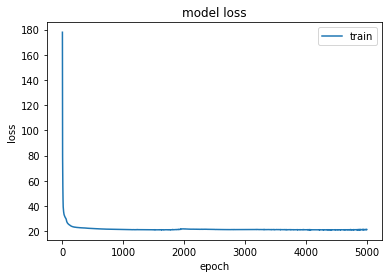

INFO:tensorflow:Assets written to: ./Data/vae_model.hf5/assets


INFO:tensorflow:Assets written to: ./Data/vae_model.hf5/assets


In [20]:
opt = RMSprop(learning_rate=0.0001)
opt = Adam(learning_rate=0.00001, clipvalue=0.5)
opt = Adam()


vae_model.compile(optimizer=opt, loss=vae_loss)
vae_model.summary()

trained = False     # First time train / Next times use saved model to speed up analysis
if trained:
    vae_model = load_model('./Data/vae_model.hf5', custom_objects={'vae_loss': vae_loss})

else:
    results = vae_model.fit(X_train, X_train,
                        shuffle=True,
                        epochs=5000,
                        batch_size=128)
    # Training figure
    plt.plot(results.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right');
    plt.show()
    # saving weights
    vae_model.save('./Data/vae_model.hf5')

In [21]:
X_train_pred = vae_model.predict(X_train)

/home/manero/DL/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [22]:
mae_vector_train = get_error_term(X_train_pred, X_train, _rmse=False)

print(f'Avg error {np.mean(mae_vector_train)}\nmedian error {np.median(mae_vector_train)}\n99Q:    \
      {np.quantile(mae_vector_train, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector_train, 0.99)} ')

error_thresh = np.quantile(mae_vector_train, 0.99)
error_thresh = np.quantile(mae_vector_train, 0.995)
error_median = np.quantile(mae_vector_train, 0.5)
print(error_thresh, error_median)

Avg error 0.050435947241632216
median error 0.04801671918723659
99Q:          0.09987715710401902
setting threshold on 0.09987715710401902 
0.1121835132062017 0.04801671918723659


<AxesSubplot:title={'center':'Distribution Plot reconstruction error ignitions'}, ylabel='Count'>

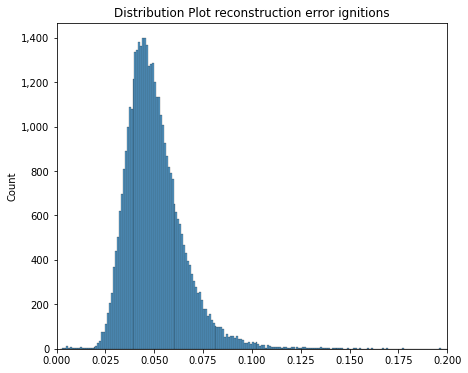

In [23]:
fig, ax = plt.subplots(figsize=(7,6))
ax.set_title('Distribution Plot reconstruction error ignitions')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xlim(0,0.2)
sns.histplot(data=mae_vector_train)

In [24]:
X_pred_test = vae_model.predict(X_test)
print('threshold', error_thresh,error_median)
#train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

mae_vector = get_error_term(X_pred_test, X_test, _rmse=False)
anomalies = (mae_vector > error_median)

np.count_nonzero(anomalies) / len(anomalies)
print('total non_ignitions',len(X_pred_test))
print('number of almost_ignitions', np.count_nonzero(anomalies==0))

#print('total y_test',len(y_test))
#print(np.count_nonzero(y_test))

threshold 0.1121835132062017 0.04801671918723659
total non_ignitions 20000000
number of almost_ignitions 4726081


In [25]:
mae_vector

array([0.09984118, 0.19130441, 0.18524234, ..., 0.06518565, 0.05459309,
       0.06232336])

-0.03596551497814136 0.7583842439689509 0.0 89877.9


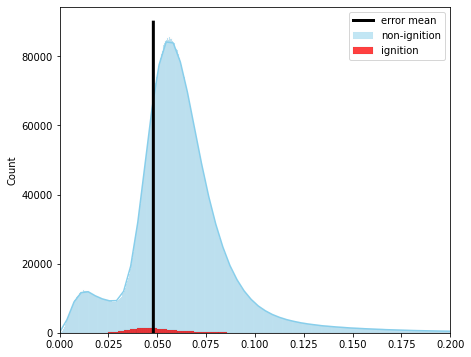

In [40]:
fig,ax1  = plt.subplots(figsize=(7,6))
sns.histplot(data=mae_vector, ax=ax1, color='skyblue', label='non-ignition', kde=True)
sns.histplot(data=mae_vector_train, ax=ax1, color='red', label='ignition')
xmin, xmax, ymin, ymax = plt.axis()
liney = np.arange(ymin, ymax, 0.01)
linex = np.ones(len(liney)) * error_median
sns.lineplot(x = linex, y= liney, color='black', ax=ax1, linewidth=3, estimator = None, label='error mean')
ax.set_title('Comparison reconstruction error ignition / non-ignition')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xlim(0,0.2)
plt.legend()
plt.show()

In [28]:
#===== program ends here. now create a new label and label non-ignition dataset with new class ===== #

In [29]:
import session_info
session_info.show(html=False)

-----
keras               2.12.0
matplotlib          3.5.0
numpy               1.22.4
pandas              1.5.3
seaborn             0.11.2
session_info        1.0.0
sklearn             1.2.1
tensorflow          2.12.0
-----
IPython             7.29.0
jupyter_client      8.2.0
jupyter_core        5.3.0
notebook            6.5.4
-----
Python 3.8.12 (default, Oct 12 2021, 13:49:34) [GCC 7.5.0]
Linux-5.19.0-45-generic-x86_64-with-glibc2.17
-----
Session information updated at 2023-06-22 20:23


### 